# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=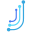)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [12]:
!pip install nhanes


In [13]:
import session_info

In [14]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

In [15]:
session_info.show()

## Importar funciones personalizadas

In [16]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [17]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [18]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type="snake"
    )
    .add_column('year', 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by= "date")
    .set_index('date')
    
)
airquality_df.head()
airquality_df.shape

(153, 7)

In [19]:
(
    smf.ols(
        formula="temp ~ ozone ",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Tue, 13 Jun 2023",Prob (F-statistic):,2.93e-18
Time:,17:38:01,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [20]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Tue, 13 Jun 2023",Prob (F-statistic):,1.47e-16
Time:,17:38:01,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [21]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df.head()
survival_df.columns
survival_df.head()


,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory


Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [22]:
(
    smf.ols(
        formula="death ~ C(chapter)",
        data = survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/Users/andressanchez/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-143.5
Date:,"Tue, 13 Jun 2023",Prob (F-statistic):,1.00
Time:,17:38:02,Log-Likelihood:,68751.
No. Observations:,2169,AIC:,-1.375e+05
Df Residuals:,2153,BIC:,-1.374e+05
Df Model:,15,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

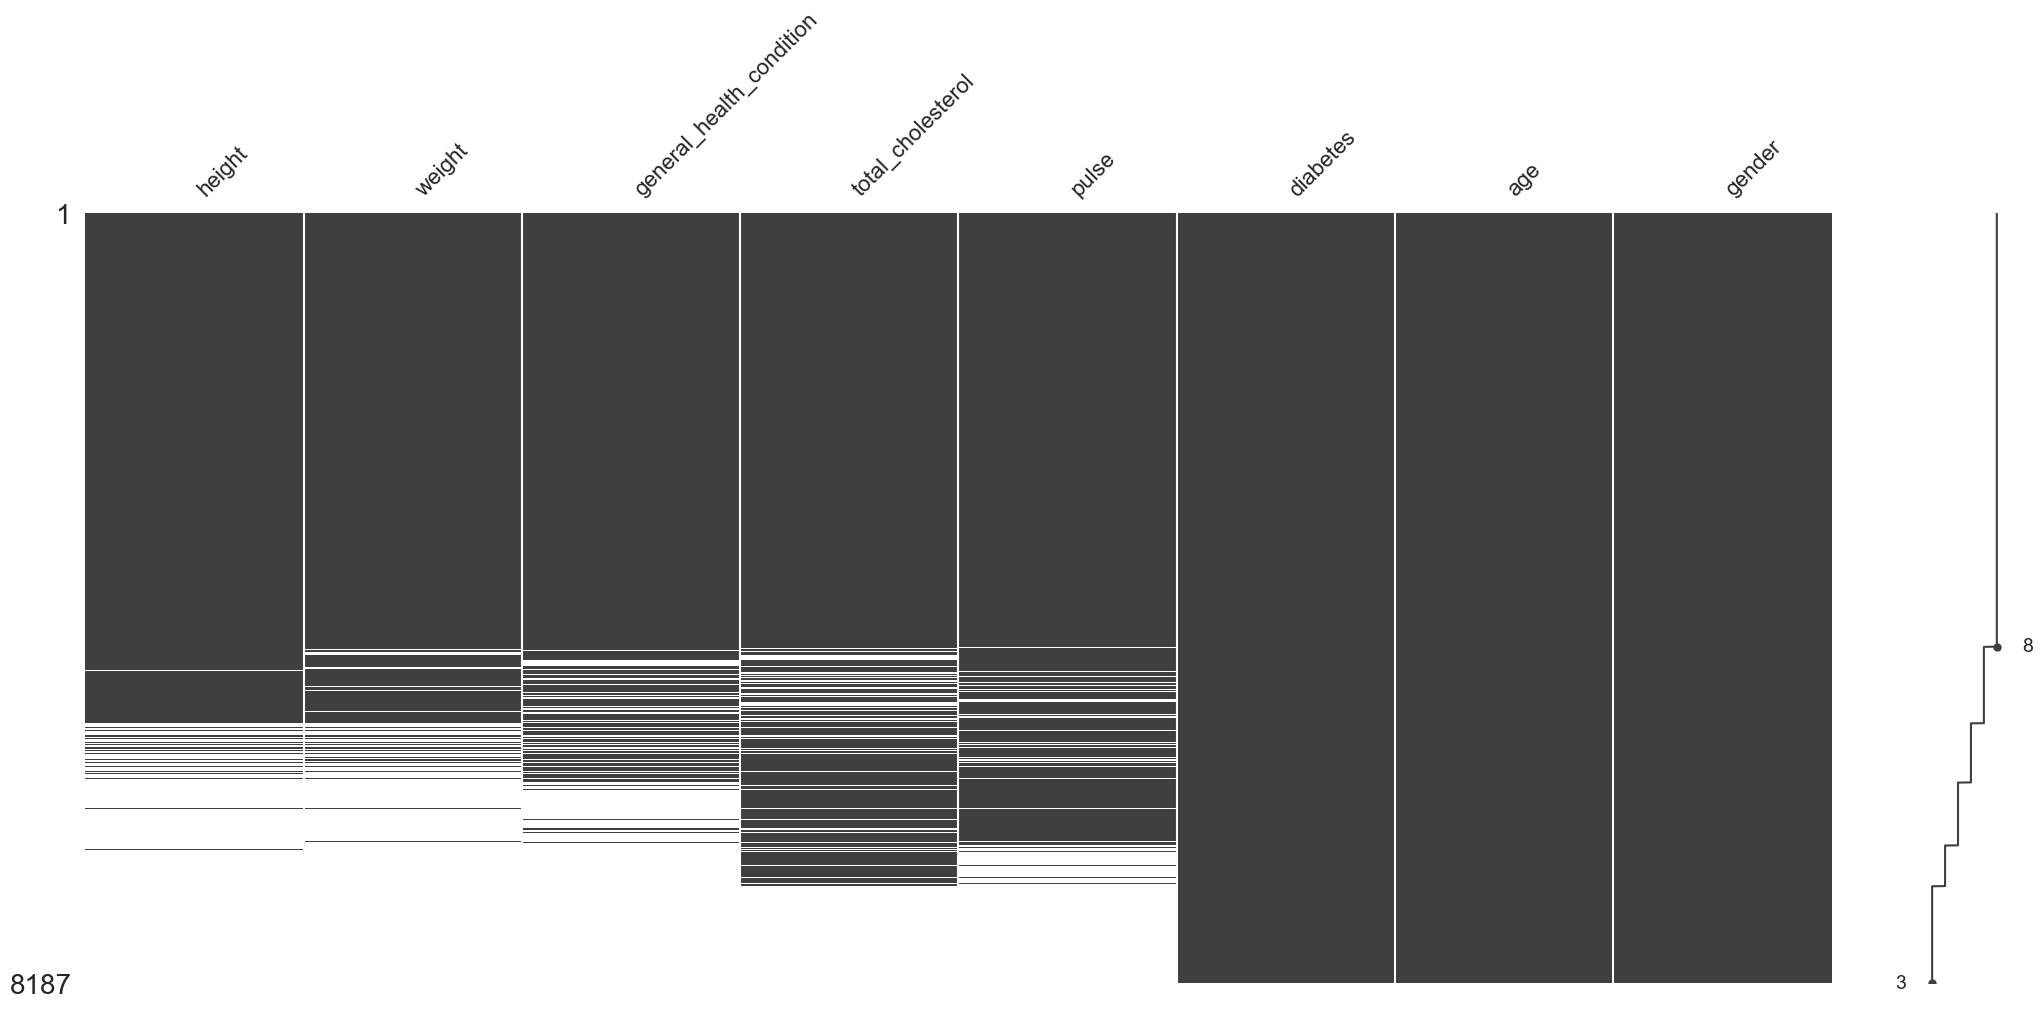

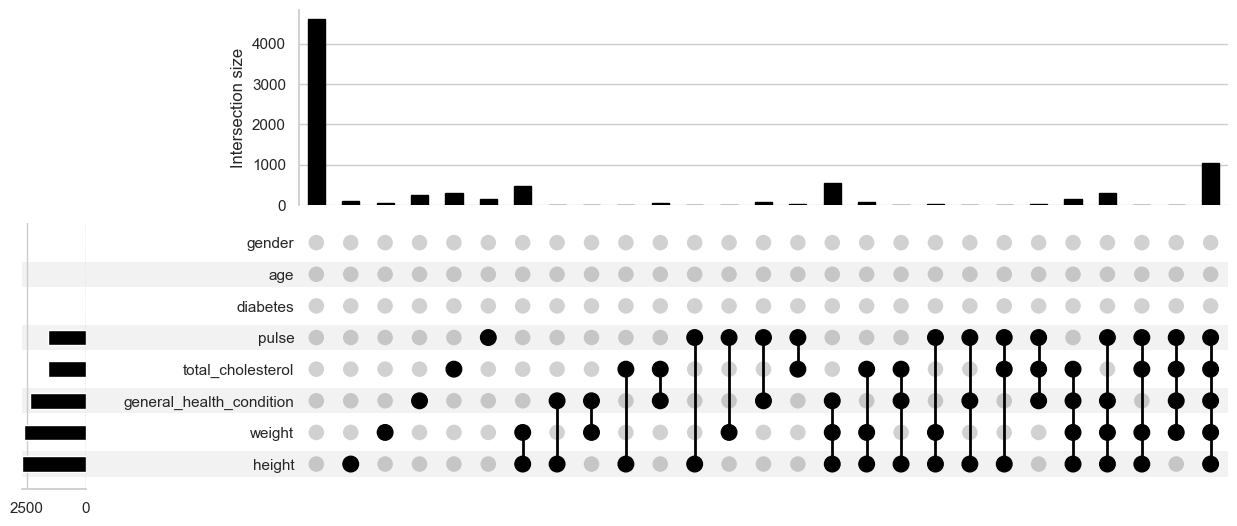

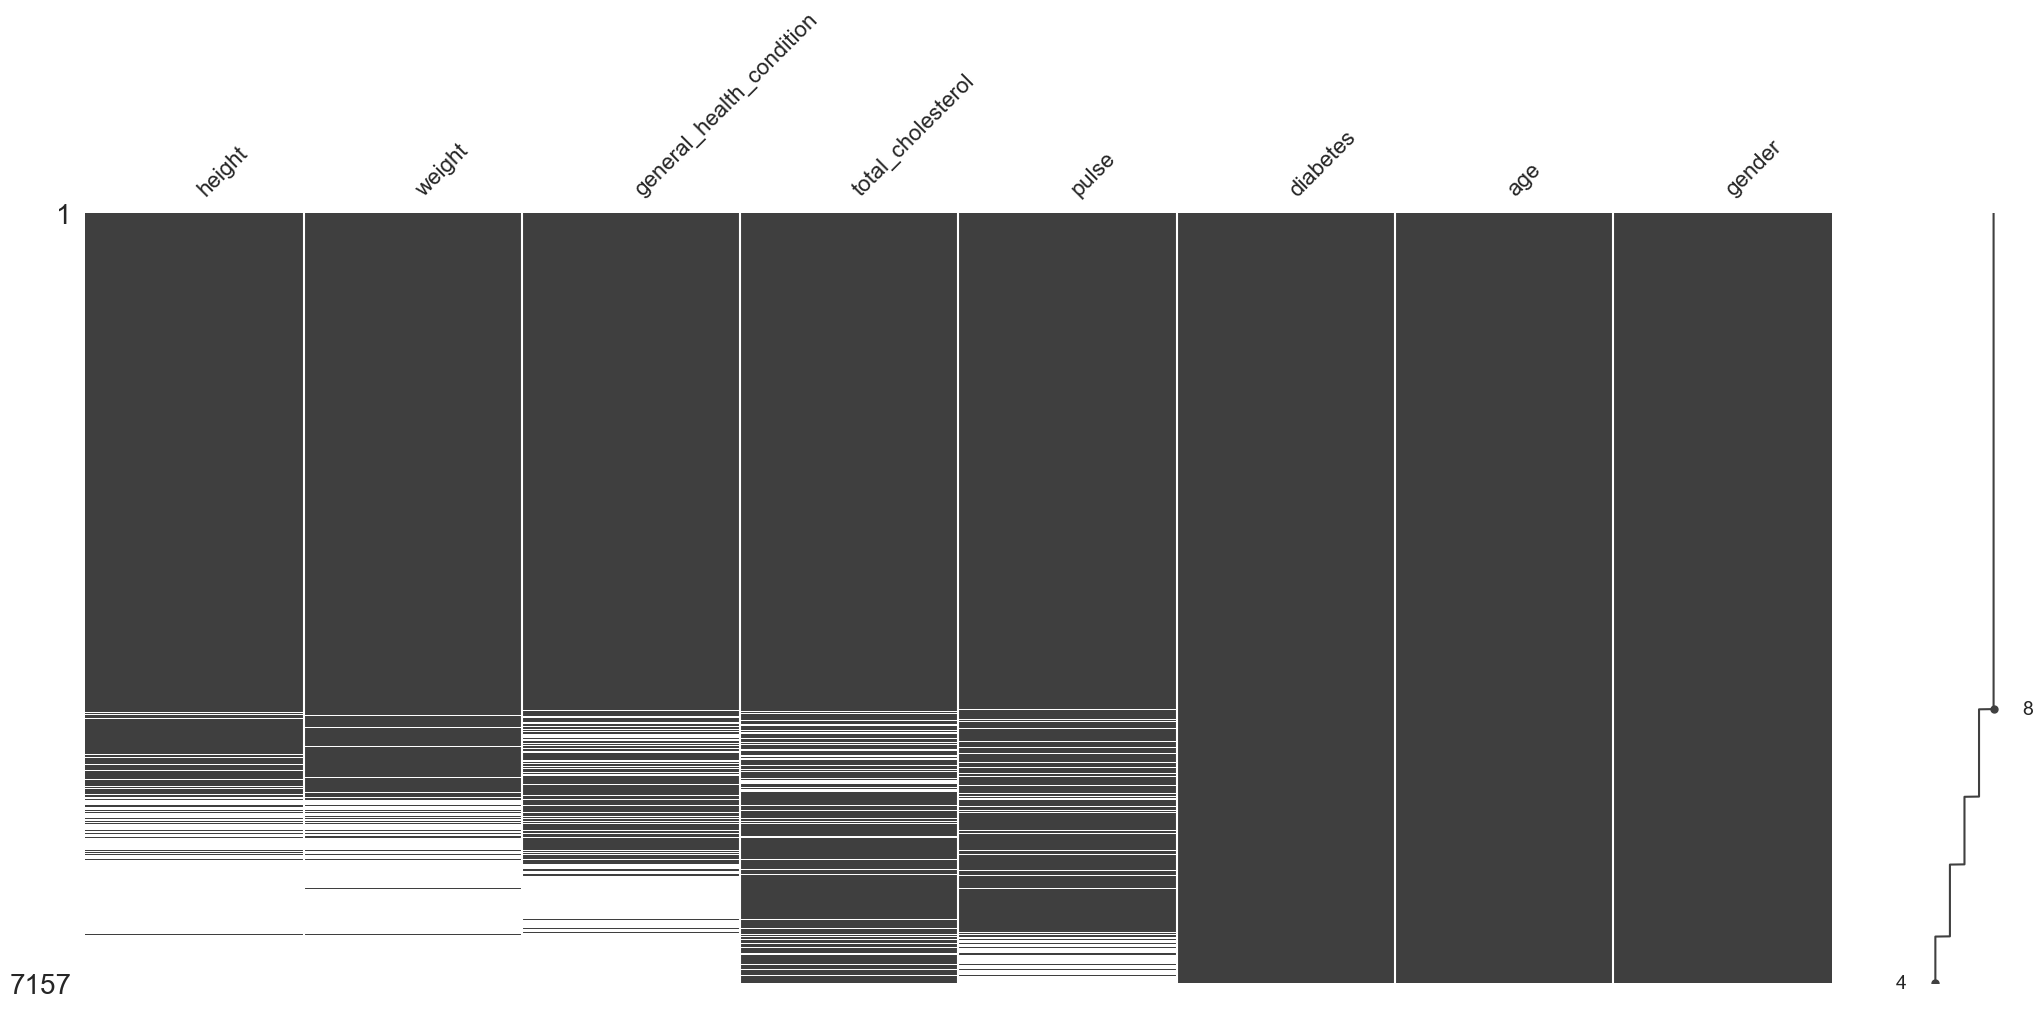

In [23]:
%run download-data-and-load-it.ipynb # Path: download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [24]:
female_weight, male_weight =(
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x: x.isna(),
        elementwise=False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)
scipy.stats.ttest_ind(
    a = female_weight,
    b= male_weight,
    alternative='two-sided',
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

## Amplía tu conjunto de herramientas para explorar valores faltantes

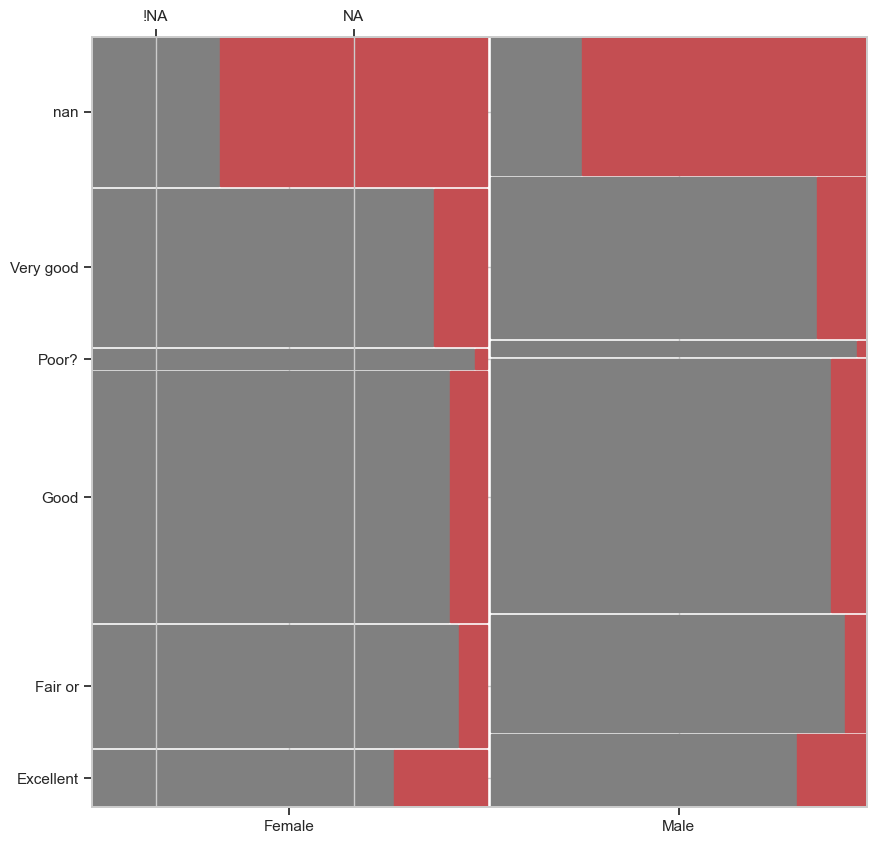

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight = lambda df: df.weight.isna().replace([True,False],['NA','!NA'])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties=lambda key: {'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key: '',
            ax = ax
        )
    )
);

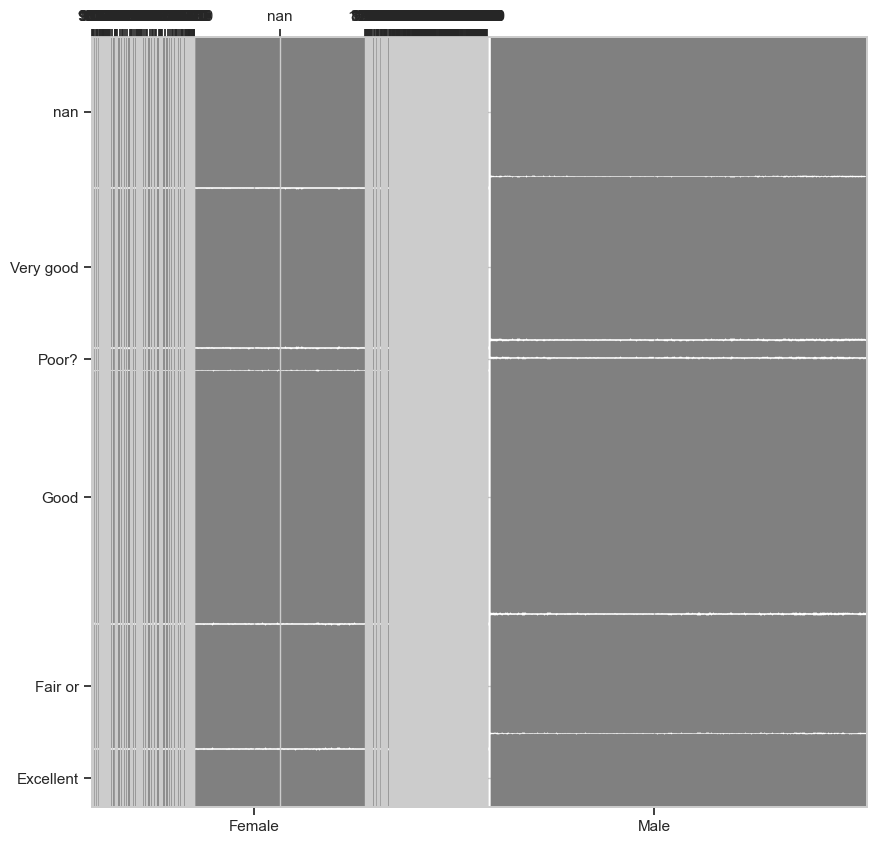

In [26]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

def missing_mosaic_plot(data, var1, var2, var_missing):
    fig, ax = plt.subplots(figsize=(10, 10))

    (
        data
        .assign(
            var_missing=lambda df: df[var_missing].isna().replace([True, False], ['NA', '!NA'])
        )
        .groupby([var1, var2, var_missing], dropna=False, as_index=True)
        .size()
        .pipe(
            lambda df: mosaic(
                data=df,
                properties=lambda key: {'color': 'r' if 'NA' in key else 'gray'},
                horizontal=True,
                axes_label=True,
                title='',
                labelizer=lambda key: '',
                ax=ax
            )
        )
    )

# Example usage:
missing_mosaic_plot(nhanes_df, 'gender', 'general_health_condition', 'weight')


## Tratamiento de variables categóricas para imputación de valores faltantes

In [27]:
nhanes_transformed_df = nhanes_df.copy(deep = True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [28]:
encoder = sklearn.preprocessing.OrdinalEncoder() # Create a new encoder

X = [['Male'],['Female'],['Female']]
X

[['Male'], ['Female'], ['Female']]

In [29]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [30]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [31]:
encoder.inverse_transform([[1],[0],[0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [32]:
categorical_columns = nhanes_df.select_dtypes(include=['object','category']).columns

In [33]:
categorical_tranformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough'
    
)

In [34]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_tranformer.fit_transform(nhanes_df),
        columns=categorical_tranformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
        .rename_columns(
        function = lambda x: x.removeprefix('remainder__'))
) # Apply categorical transformer to the data
nhanes_transformed_df.head()

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0


### _One Hot Encoding_

In [35]:
nhanes_transformerd_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [36]:
(
    nhanes_transformerd_df2
    .select_columns('general_health_condition')
    #.head(10)
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

In [37]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),['gender']),
    (sklearn.preprocessing.OneHotEncoder(), ['general_health_condition']),
    remainder='passthrough'
)

In [38]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__'))
        
    .rename_columns(
        function = lambda x: x.removeprefix('onehotencoder__'))
) # Apply categorical transformer to the data
nhanes_transformed_df2.head()

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0


In [39]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [40]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X = [[0,0,1,0,0,0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [46]:
(
    nhanes_df
    # janitor
    .transform_column(
        'height',
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676386

<AxesSubplot:xlabel='height', ylabel='weight'>

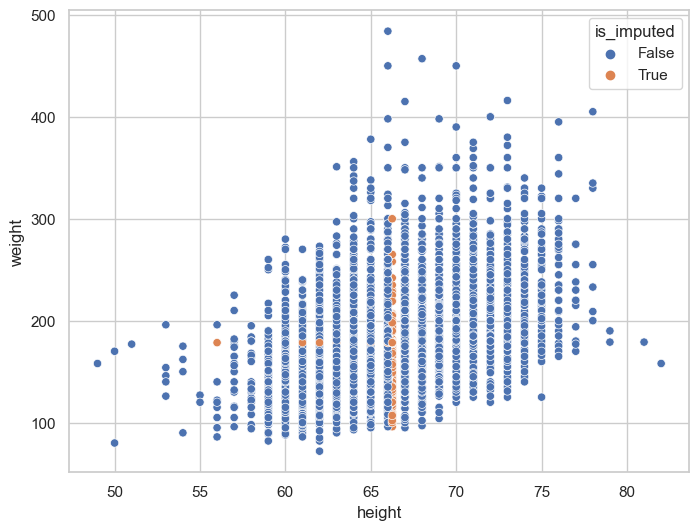

In [50]:
(
    nhanes_df
    .select_columns('height','weight')
    .missing.bind_shadow_matrix(True,False,suffix='_imp')
    .assign(
        height = lambda df: df.height.fillna(value=df.height.mean()),
        weight = lambda df: df.weight.fillna(value=df.weight.mean())
)
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
    )
)

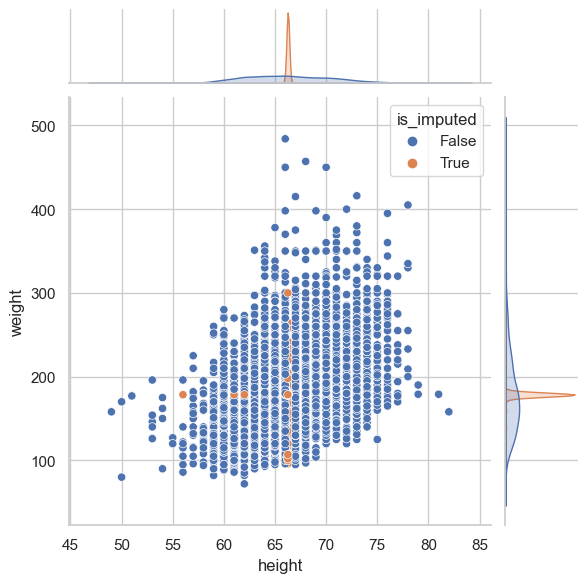

In [51]:
(
    nhanes_df
    .select_columns('height','weight')
    .missing.bind_shadow_matrix(True,False,suffix='_imp')
    .assign(
        height = lambda df: df.height.fillna(value=df.height.mean()),
        weight = lambda df: df.weight.fillna(value=df.weight.mean())
)
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        show_marginal = True,
        
    )
)

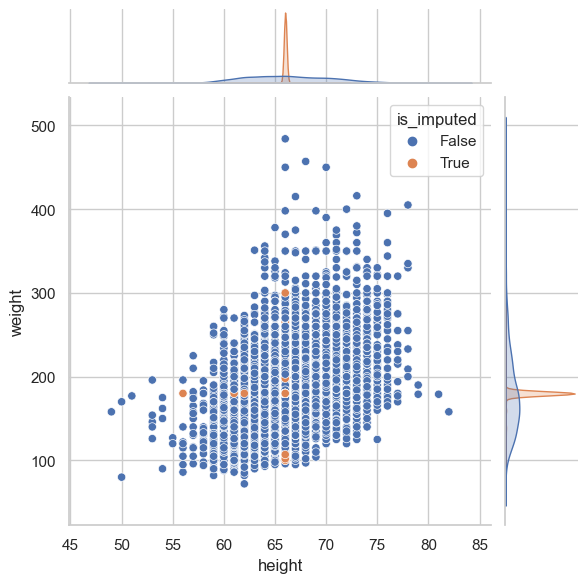

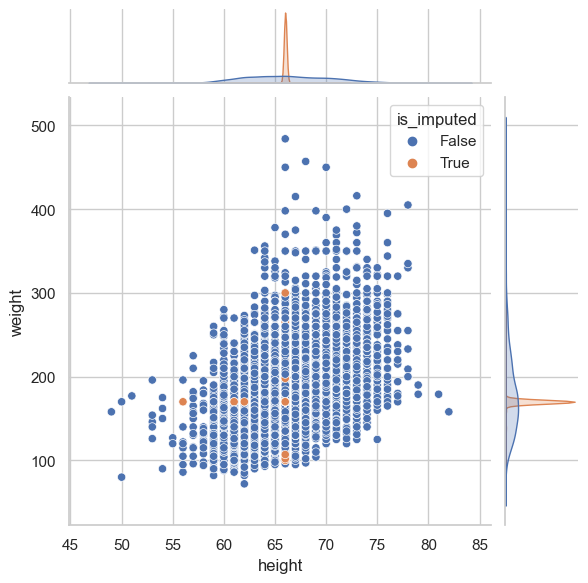

In [52]:
# Imputación utilizando la moda
df_mode = (
    nhanes_df
    .select_columns('height', 'weight')
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mode().values[0]),
        weight=lambda df: df.weight.fillna(value=df.weight.mode().values[0])
    )
)

# Imputación utilizando la mediana
df_median = (
    nhanes_df
    .select_columns('height', 'weight')
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(
        height=lambda df: df.height.fillna(value=df.height.median()),
        weight=lambda df: df.weight.fillna(value=df.weight.median())
    )
)

# Gráfico de dispersión para imputación con moda
df_mode.missing.scatter_imputation_plot(
    x='height',
    y='weight',
    show_marginal=True
)

# Gráfico de dispersión para imputación con mediana
df_median.missing.scatter_imputation_plot(
    x='height',
    y='weight',
    show_marginal=True
)


## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [55]:
(
    nhanes_df
    .select_columns('height','weight')
    #.fillna(method='ffill')
    .ffill()
    
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [56]:
(
    nhanes_df
    .select_columns('height','weight')
    #.fillna(method='bfill')
    .bfill()
    
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [60]:
(
    nhanes_df
    .select_columns('height','weight','gender','diabetes','general_health_condition')
    .sort_values(
        by=['gender','diabetes','general_health_condition','height'],
        ascending=True
    )
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise=False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


In [63]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
)

/var/folders/3j/6x57938974z0qwy867642sz00000gn/T/ipykernel_3680/909901090.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.ffill())


,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94195.0,63.0,90.0,Female,0,Excellent
95793.0,61.0,96.0,Female,0,Excellent
101420.0,59.0,98.0,Female,0,Excellent
94148.0,65.0,100.0,Female,0,Excellent
102062.0,62.0,100.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96869.0,72.0,298.0,Male,1,NaN
97267.0,72.0,298.0,Male,1,NaN


## Imputación por interpolación

(<AxesSubplot:xlabel='date'>,)

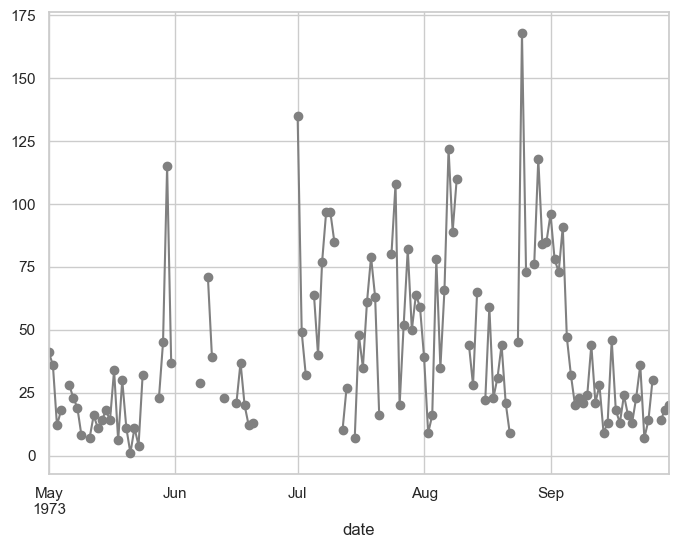

In [65]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.plot(color='gray',marker='o'),
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

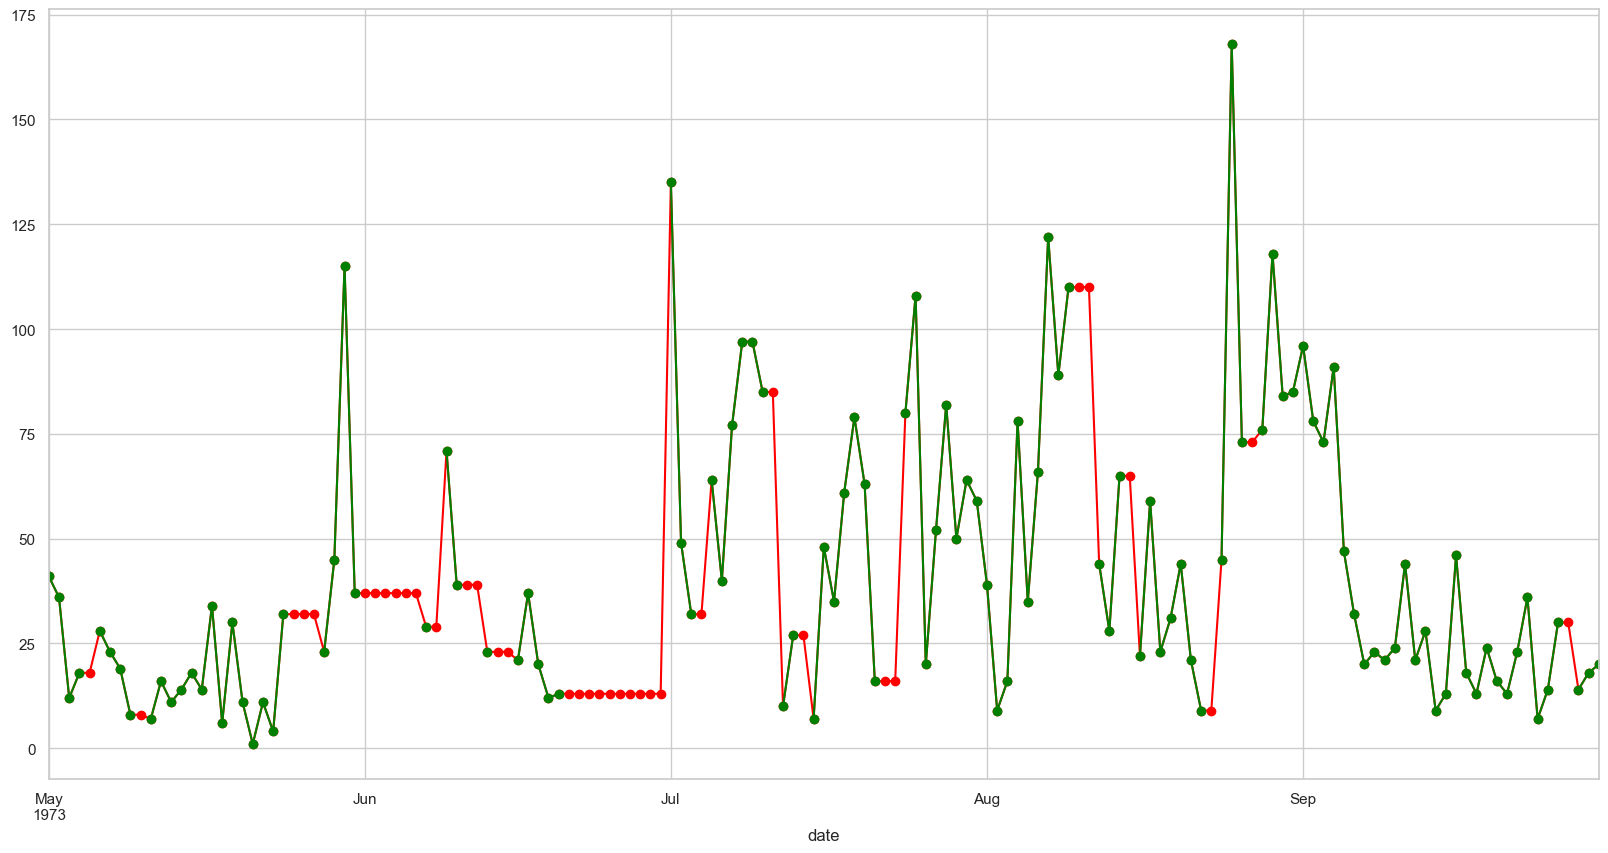

In [70]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color='red',marker='o'),
            df.ozone.plot(color='green',marker='o'),
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

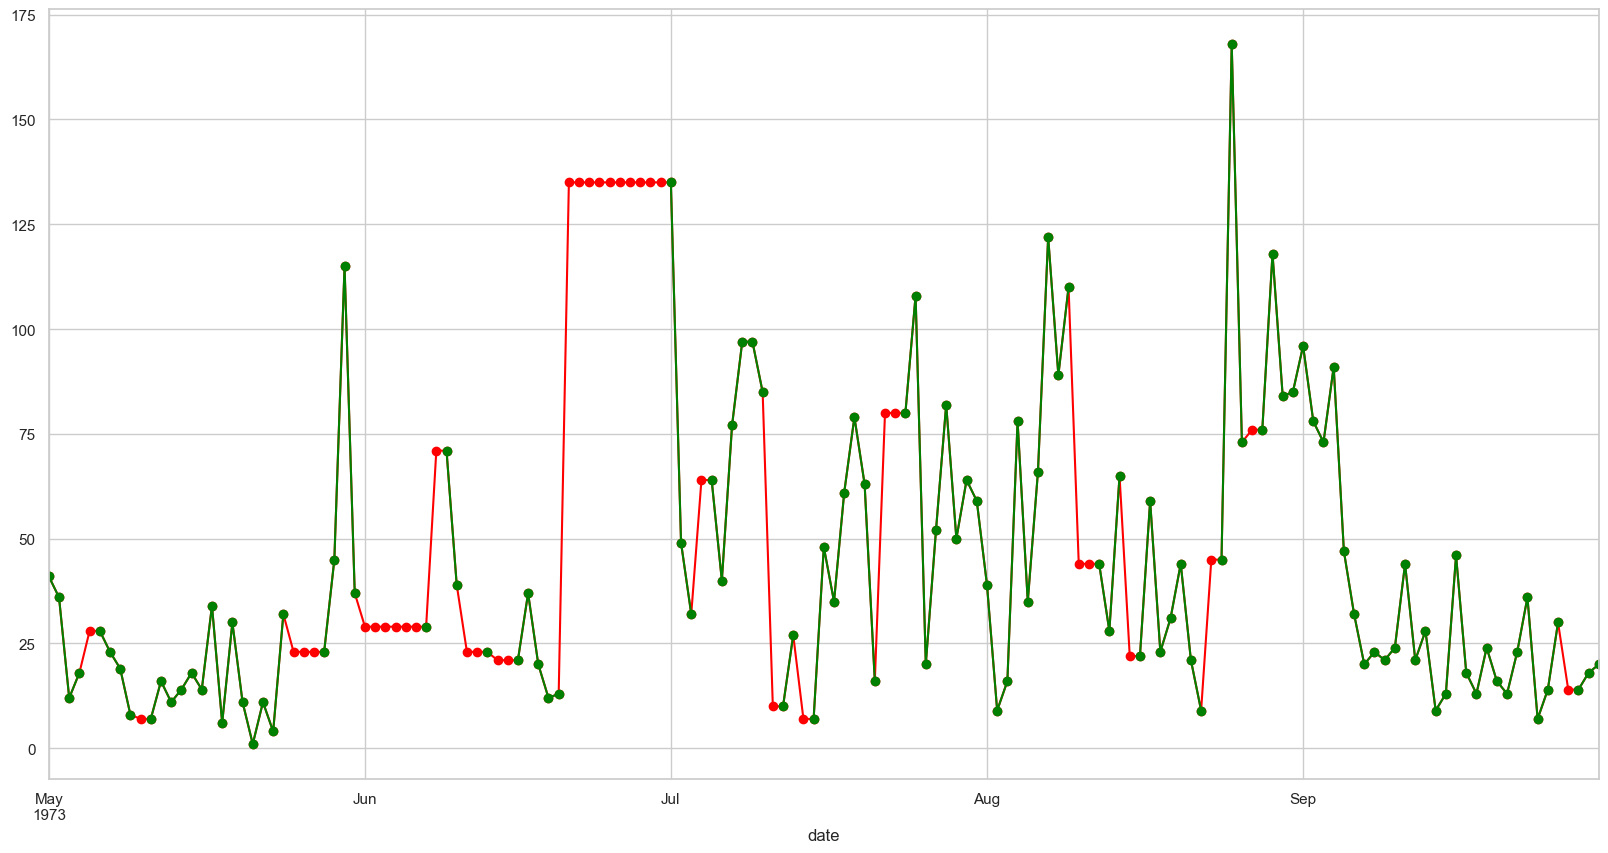

In [71]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color='red',marker='o'),
            df.ozone.plot(color='green',marker='o'),
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

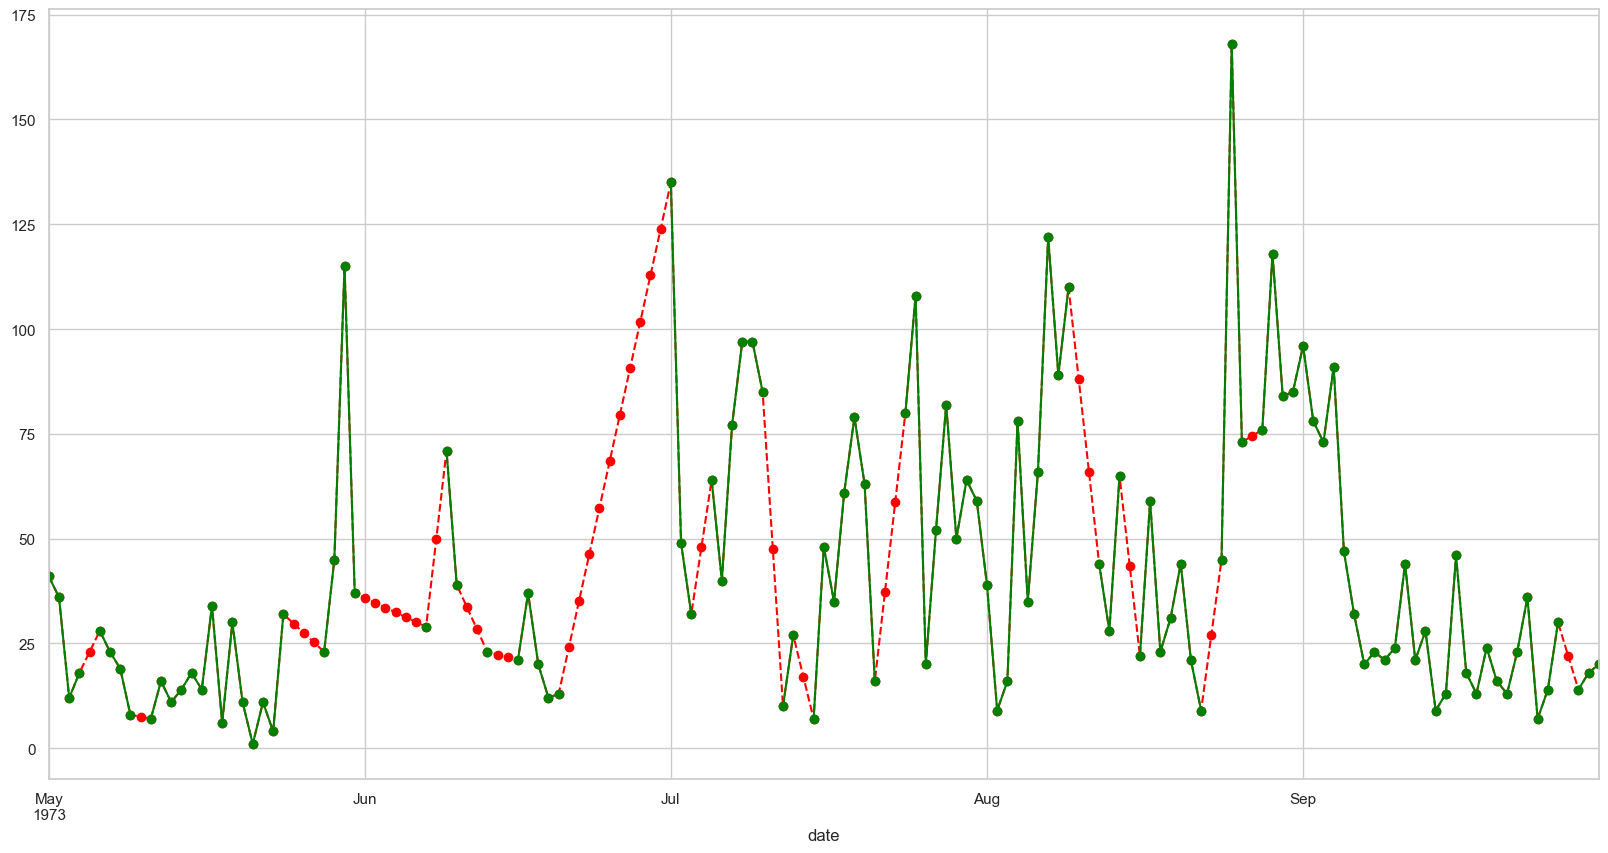

In [74]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='linear').plot(color='red',marker='o',linestyle='dashed'),
            df.ozone.plot(color='green',marker='o'),
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

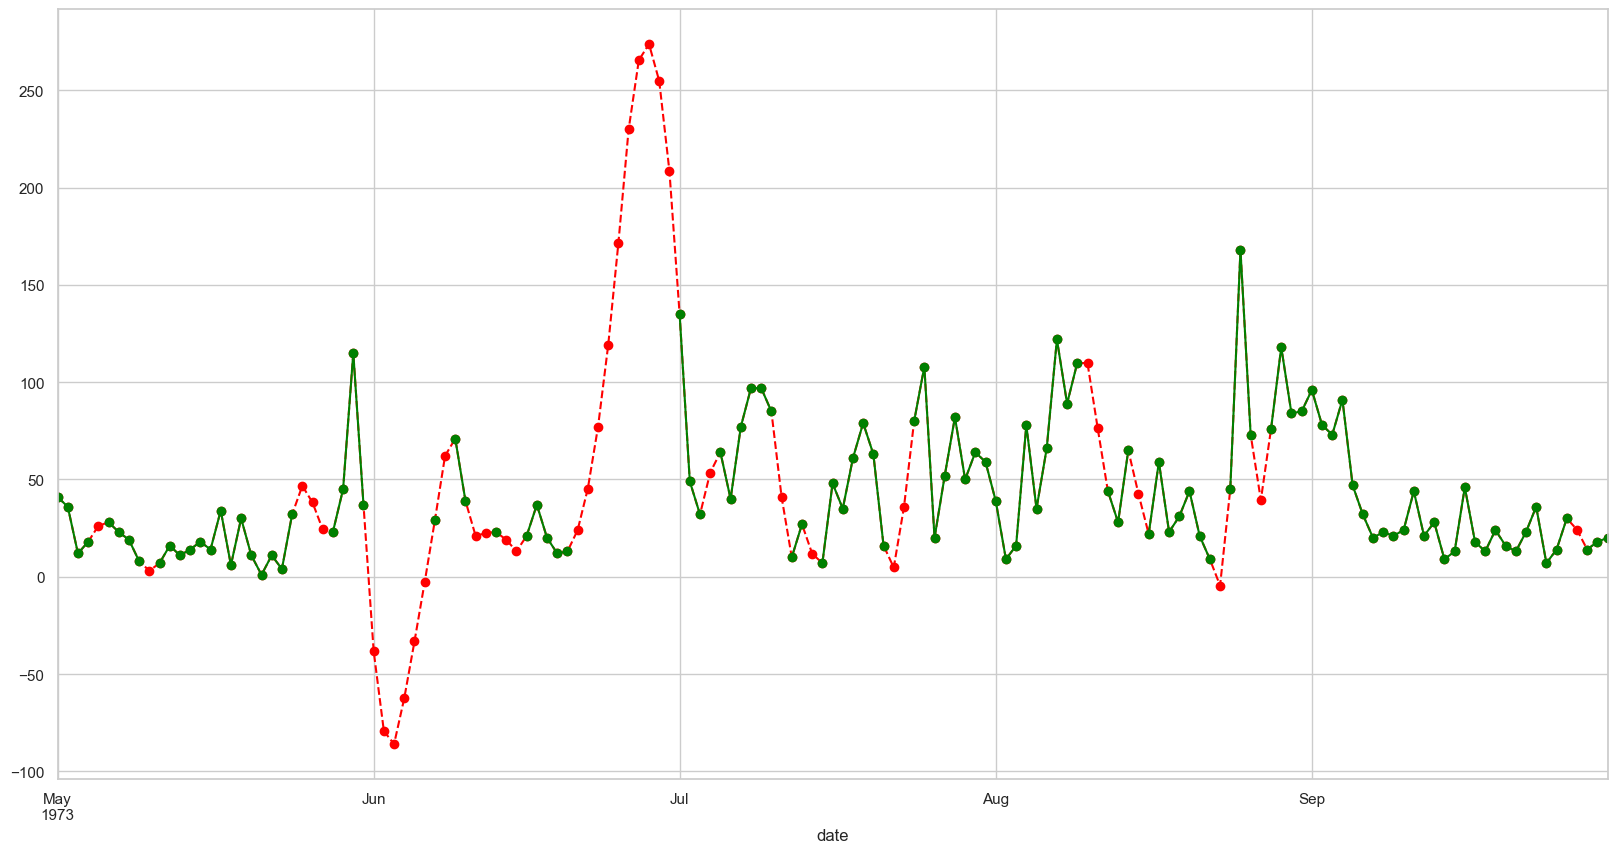

In [75]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='quadratic').plot(color='red',marker='o',linestyle='dashed'),
            df.ozone.plot(color='green',marker='o'),
        )
    )
)

(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

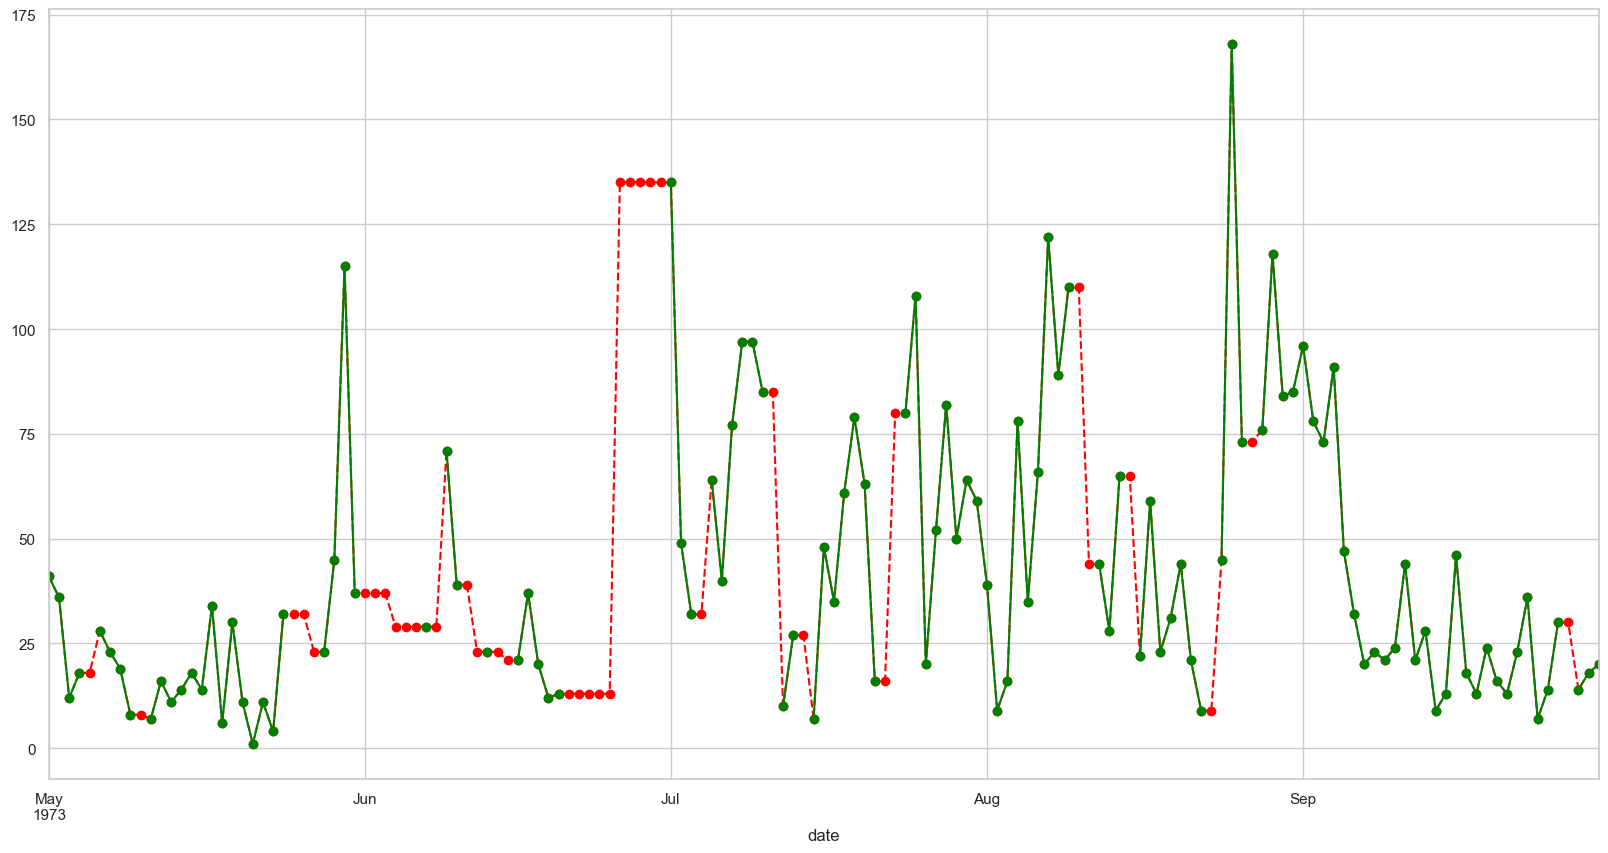

In [76]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='nearest').plot(color='red',marker='o',linestyle='dashed'),
            df.ozone.plot(color='green',marker='o'),
        )
    )
)

In [79]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method='linear')

In [81]:
airquality_df.head(20)

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,23.0,NaN,14.3,56,5,5,1973
1973-05-06,28.0,NaN,14.9,66,5,6,1973
1973-05-07,23.0,299.0,8.6,65,5,7,1973
1973-05-08,19.0,99.0,13.8,59,5,8,1973
1973-05-09,8.0,19.0,20.1,61,5,9,1973


## Imputación por algoritmo de vecinos más cercanos (KNN)

In [82]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [83]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [90]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_df_knn.head(20)

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
93712.0,2.0,1.0,68.0,135.0,182.0,68.0,0.0,18.0
93713.0,4.0,1.0,70.0,165.0,184.0,90.0,0.0,67.0
93714.0,2.0,0.0,60.0,210.0,230.0,90.0,1.0,54.0
93715.0,1.0,1.0,68.0,154.0,180.0,66.0,0.0,71.0


<AxesSubplot:xlabel='height', ylabel='weight'>

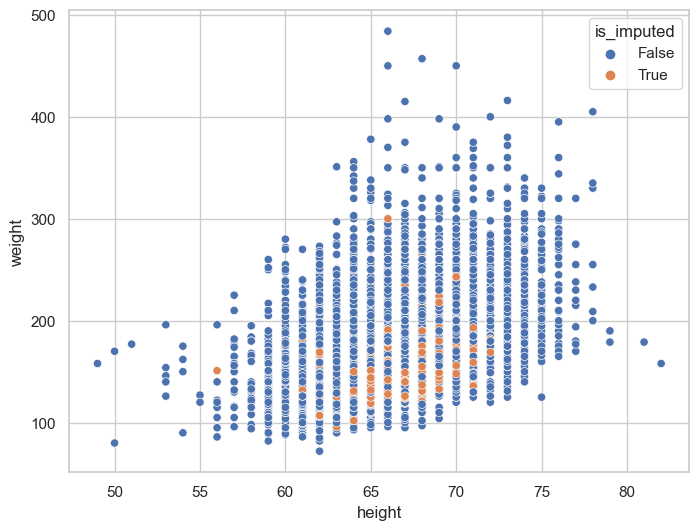

In [91]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix='_imp',only_missing=True)
        ],
        axis=1
    )
     .missing.scatter_imputation_plot(
         x='height',
         y='weight',
     )   
        
) # Apply categorical transformer to the data use knn imputer to impute missing values and plot the results in a scatter plot

### Ordenamiento por cantidad de variables faltantes

In [92]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round()
nhanes_df_knn.head(20)

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,0.0,75.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0
93712.0,1.0,0.0,18.0,68.0,182.0,2.0,135.0,68.0
93713.0,1.0,0.0,67.0,90.0,184.0,4.0,165.0,70.0
93714.0,0.0,1.0,54.0,90.0,230.0,2.0,210.0,60.0
93715.0,1.0,0.0,71.0,66.0,180.0,1.0,154.0,68.0


<AxesSubplot:xlabel='height', ylabel='weight'>

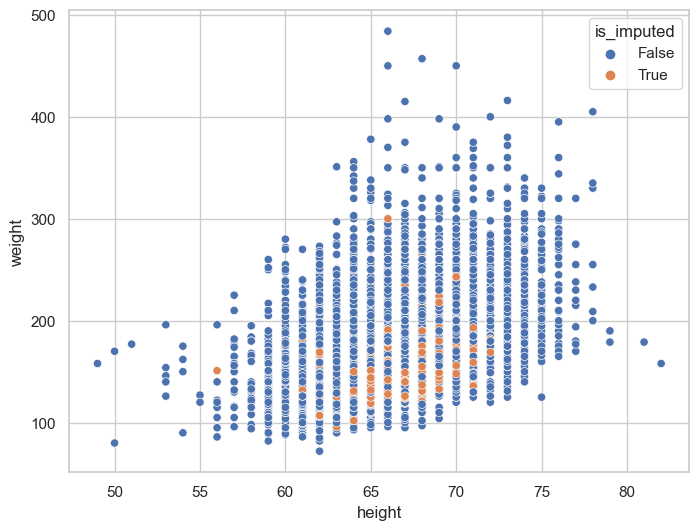

In [93]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix='_imp',only_missing=True)
        ],
        axis=1
    )
     .missing.scatter_imputation_plot(
         x='height',
         y='weight',
     )   
        
) 

## Imputación basada en modelos

In [114]:
nhanes_model_df = (
    nhanes_df
    .select_columns('height','weight','gender','age')
    .sort_values(by='height')
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise=False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix='_imp',
        only_missing=False
        )
)
nhanes_model_df.head(20)

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
102826.0,53.0,140.0,Female,58.0,False,False,False,False
94260.0,53.0,154.0,Female,48.0,False,False,False,False
95094.0,53.0,126.0,Female,37.0,False,False,False,False


In [115]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols('height ~ weight + gender + age', data=df)
    )
    .fit()
)

In [116]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)
ols_imputed_values.head(20)

SEQN
93707.0    69.0
93719.0    64.0
93733.0    64.0
93736.0    69.0
93737.0    69.0
93741.0    64.0
93744.0    64.0
93747.0    64.0
93751.0    64.0
93753.0    64.0
93760.0    64.0
93769.0    70.0
93779.0    65.0
93781.0    68.0
93787.0    64.0
93793.0    68.0
93803.0    68.0
93807.0    64.0
93808.0    68.0
93810.0    68.0
dtype: float64

In [117]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values
nhanes_model_df.head(20)

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
102826.0,53.0,140.0,Female,58.0,False,False,False,False
94260.0,53.0,154.0,Female,48.0,False,False,False,False
95094.0,53.0,126.0,Female,37.0,False,False,False,False


<AxesSubplot:xlabel='weight', ylabel='height'>

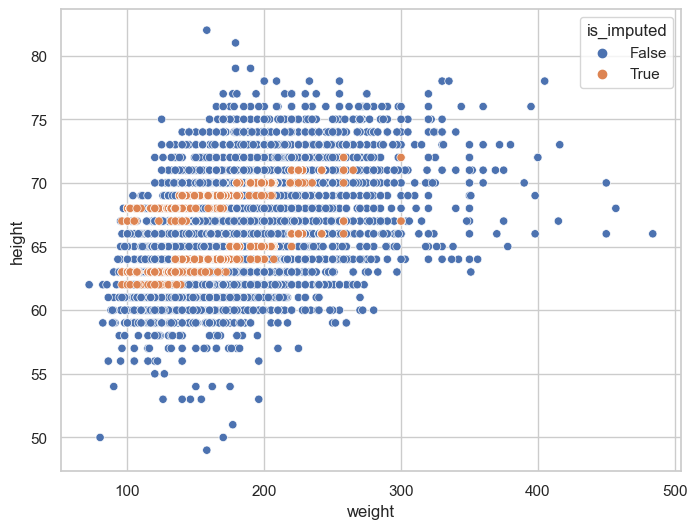

In [118]:
(
    nhanes_model_df
    .missing.scatter_imputation_plot(
        x='weight',
        y='height',
    )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

<AxesSubplot:xlabel='height', ylabel='weight'>

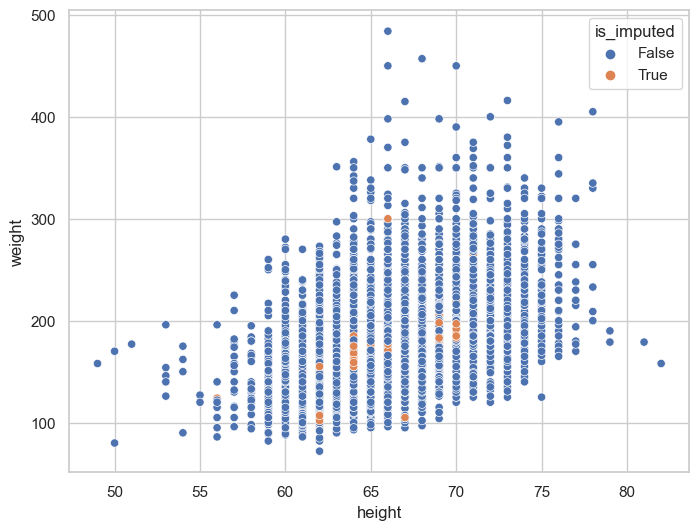

In [136]:
# crea las copias, las analiza y regresa un solo conjunto de datos. 
# Tambien puedes pedir que retorne todos las copias 

mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),  # metodo seleccionado para estimar los missing
    initial_strategy='mean',    # estimador seleccionado
    imputation_order='ascending'# ordena las variables segun la cantidad de valores faltantes
    
)

# creamos una copia de los datos ya transformado

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

# ajustar y transformar los datos

# puedes pasar como parametro nhanes_df o nhanes_mice_df
# por defecto pasamos nhanes_df porque sobreescribe los valores del dataframe que copiamos
# redondeamos los numeros en este caso
# agrega los valores imputados al dataset

nhanes_mice_df.iloc[:, :] =  mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix='_imp')
    ],
    axis=1
)
nhanes_mice_df.missing.scatter_imputation_plot(
    x='height',
    y='weight',
)

## Transformación inversa de los datos

In [137]:
nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

In [144]:
nhanes_imputed_df[categorical_columns]=(
    categorical_tranformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)
nhanes_imputed_df.head(20)

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp,diabetes_imp,age_imp,gender_imp
SEQN,,,,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0,False,False,True,False,False,False,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0,False,False,False,False,False,False,False,False
93712.0,Good,Male,68.0,135.0,182.0,68.0,0.0,18.0,False,False,False,False,False,False,False,False
93713.0,Very good,Male,70.0,165.0,184.0,90.0,0.0,67.0,False,False,False,False,False,False,False,False
93714.0,Good,Female,60.0,210.0,230.0,90.0,1.0,54.0,False,False,False,False,False,False,False,False
93715.0,Fair or,Male,68.0,154.0,180.0,66.0,0.0,71.0,False,False,False,False,False,False,False,False


In [145]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [146]:
nhanes_imputed_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [149]:
nhanes_imputed_df.missing.number_missing()

0

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [41]:
session_info.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>